# What goes into a Landlab model?

In the previous section, {ref}`Grid <grid-user-guide>` we showed you most of the core
functionality of the Landlab grid. 

In this section, we introduce you to how to
actually use it to build models and work with the Landlab component library.

Using Landlab requires that you build a Python script to import, instantiate,
and then run your landscape model. We describe such a script as a **driver**.
It's also possible to do the same set of processes on the fly in an interactive
Python environment like iPython.

Typically, a driver file will consist of six distinct sections:

- **Import** the Python and Landlab libraries you'll need to run your model
- **Instantiate** the Landlab elements (grid and, if using them, components)
- **Load** any necessary data into the grid fields
- Set the **boundary conditions**
- **Run** the model, typically by creating a for loop or using a Landlab generator (see below)
- **Finalize** and handle the data (e.g., plot, export)

Beyond the driver, if you're using Landlab components, you'll probably also need
a {ref}`parameter file<input-files>`. This file supplies the components with the additional
parameter and setup information they need. Landlab parameter files are text
files `.txt`, have fixed format, and for convenience (so you only have to
specify the minimum of path information in the file name) should be placed in
the same folder as the driver file. Find out more about parameter files
{ref}`here<input-files>`. However, if you're not using components, there's little need
to create a parameter file; you can just directly pass other parameters to the grid
in the driver.


## A brief introduction to components

A key strength of Landlab is that not only is it designed to make implementing
your own process simulations as simple as possible, but it also offers an
off-the-shelf library of pre-designed process descriptions that you can use in
your drivers. We call these process simulators Landlab **components**. The
intention is that each component be:

- Plug-and-play
- Interoperable with all other components
- Implementable in your driver in only one or two lines of code

By no means is using the component library necessary or even always
desirable when working with Landlab. However, we hope that components will dramatically reduce the time investment needed to implement
a wide variety of modeling scenarios. In particular, components should make
producing models that couple more than one process significantly easier because
existing, off-the-shelf components can be slotted in alongside novel process
descriptions.

A list of the current components is found within the Reference guide
{ref}`components section <api-components>`.

>**NOTE**
> Not all components will run under all conditions, but any
> limitations should be made clear in the documentation associated with
> that component.


Some components may demand you are running on a regular grid. It
should also be emphasized that most of these components are still under
active development within this beta release of Landlab, and may behave in
idiosyncratic ways or be subject to sudden changes with little or no warning. In
all cases, before setting out on any major research challenges using a
component, we'd recommend contacting the original coder of the component to let
them know they have external users to think about!

## Implementing a Landlab driver

As noted above, the process of creating a driver is essentially equivalent
whether you want to implement Landlab components, purely use your own code, or
combine some mixture of the two. Here, we take a closer look at the various
steps.

### 1. Import the libraries and functions you need

Landlab handles a lot like NumPy, and like NumPy you'll need to import the
various libraries and functions that you'll want to use. At the very least, we
suspect you'll need from outside Landlab:

- *NumPy* itself
- rudimentary Pylab plotting routines: *plot*, *show*, *figure*

Also useful can be:

- the Python module *time*, to time various parts of your code elements
- from *SciPy*, the scientific computing library. Lots of useful methods (e.g.,
  matrix solutions, curve fitting) can be found in here, to avoid reinventing
  the wheel.

From inside Landlab, you'll also need:

- A **grid** class—choose from {py:class}`RasterModelGrid <landlab.grid.raster.RasterModelGrid>`,
  {py:class}`landlab.grid.voronoi.VoronoiDelaunayGrid <landlab.grid.voronoi.VoronoiDelaunayGrid>`,
  or some of the more specialized classes listed on the
  {ref}`grid documentation page <api-grid>`.
- Any **components** you want to run
- Any Landlab **utilities** you need, such as plotters (
  {py:func}`imshow_grid <landlab.plot.imshow>`) or
  {py:mod}`io functions <landlab.io>`.

A specific example might be:

In [104]:
import numpy as np 
from pylab import show, figure, plot
import time
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FastscapeEroder
from landlab.components import FlowDirectorSteepest
from landlab.components import DepressionFinderAndRouter
from landlab.components import LinearDiffuser
import matplotlib as mpl
import matplotlib.pyplot as plt
from landlab import load_params

### 2. Instantiate objects
As noted in previous sections, Landlab is coded in an [object-oriented style](https://code.tutsplus.com/articles/python-from-scratch-object-oriented-programming--net-21476).
This means that we need to "instantiate" the various Landlab objects such as
the grid and the components that we will use to store data and run the model.

> **NOTE**
> most components require the grid object be passed to them as one of
> their arguments during instantiation, so the first thing you'll want to
> instantiate will be the grid.

Check the docstrings for each class (grid, component) you want to instantiate
for a detailed description of what you need to supply as arguments.

In this example, the grid class is the RasterModelGrid, labeled as `((i, j), [node_spacing])`. Here, `(i, j)` is a tuple where *i* is the number of rows and *j* the number of columns, and `node_spacing` is an optional second tuple or float. If you want uniform node spacing in the *y* and *x* directions, use a float, otherwise use a tuple to specify `(dy, dx)` if you want them to be different (see example immediately below). Spacing will default to (1., 1.). 

Landlab also recognizes an older style of RasterModelGrid signature, which looks like `(number_of_node_rows, number_of_node_columns, node_spacing(optional))`, and is clever enough to work with this form.

For a VoronoiDelaunayGrid, the signature will be `(array_of_node_x_coords, array_of_node_y_coords)`. For a generic component, it will typically be `(ModelGrid, 'path_to_parameter_file.txt')`, though there may be some variation, and optional inputs may also be available.

Give each object you instantiate a variable name. We like `mg` for ModelGrid
objects and some appropriate abbreviation for a component.

An example might be:

In [108]:
mg = RasterModelGrid((10, 10), xy_spacing = (1.0, 2.0))  # 100 nodes, dy=1., dx=2.
_ = mg.add_field(
    "topographic__elevation",
    mg.node_x + mg.node_y,
    at="node",
)
fr = FlowAccumulator(mg, "topographic__elevation", flow_director=FlowDirectorSteepest)

### 3. Load/create data in fields

({ref}`See this section<fields>` if you don't know what a Landlab field is.)

Now we need some data to work with. We will assume that you're going to be
working with a DEM-style elevation map across the nodes of the grid, but similar
considerations would apply for any other type of data.

You will likely be in one of two situations regarding the initial data you want
to put on the grid—either you will have some external data source that you want
to load in and use as your initial conditions (e.g., a DEM of some basin, or
some other real topography), or you want to set up some simple analytical
initial condition like a flat surface with noise or an inclined surface.

In both cases, we advocate a two step process: creating a NumPy array of the
data, then loading it into the grid as a field. We can illustrate both of
the above cases:

In [68]:
mg = RasterModelGrid((5, 4), xy_spacing=(10.0, 10)) #xy_spacing w/ 20 nodes dy = 10 dx = 10
topographic__elevation = [   #predefined topographic elevation must be defined before using FlowAccumulator
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 21.0, 10.0, 0.0],
    [0.0, 31.0, 20.0, 0.0],
    [0.0, 32.0, 30.0, 0.0],
    [0.0, 0.0, 0.0, 0.0],
]

_ = mg.add_field("topographic__elevation", topographic__elevation, at="node") #where mg is added to the initial grid

In [69]:
fa = FlowAccumulator(mg, "topographic__elevation", flow_director=FlowDirectorSteepest) #attach the flowaccumulator using the initial grid.
fa.run_one_step()

In [70]:
runoff_rate = np.arange(mg.number_of_nodes, dtype=float) #if we want to see the run-off rate
rnff = mg.add_field("water__unit_flux_in", runoff_rate, at="node", clobber=True)
mg.at_node["flow__receiver_node"].reshape(mg.shape)

array([[ 0,  1,  2,  3],
       [ 4,  1,  2,  7],
       [ 8,  8, 11, 11],
       [12, 12, 15, 15],
       [16, 17, 18, 19]])

In [113]:
#when the raster grid is in a depression
mg = RasterModelGrid((10, 10), xy_spacing=1.0)

z = mg.add_field("topographic__elevation", mg.node_x.copy(), at="node")

z = np.zeros(100, dtype=float)  # make a flat surface, elev 0
#or..
z += 0.01 * mg.node_y # a flat surface dipping shallowly south
# add a little noise to the surface:
z += np.random.rand(100) / 10000.0


mg.at_node["topographic__elevation"].reshape(mg.shape)[2:5, 2:5] *= 0.1
fa = FlowAccumulator(mg, "topographic__elevation",flow_director="FlowDirectorD8", depression_finder=DepressionFinderAndRouter)
fa.run_one_step()

In [72]:
print(mg) #print out of the grid. 

#Below we can see the dimensions it has and the type of variables it holds.

<xarray.Dataset>
Dimensions:         (node: 49, link: 84, Two: 2, patch: 36, max_patch_links: 4,
                     cell: 25, face: 60)
Coordinates:
  * node            (node) int32 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48
Dimensions without coordinates: link, Two, patch, max_patch_links, cell, face
Data variables:
    mesh            <U1 'a'
    y_of_node       (node) float64 0.0 0.0 0.0 0.0 0.0 ... 3.0 3.0 3.0 3.0 3.0
    x_of_node       (node) float64 0.0 0.5 1.0 1.5 2.0 ... 1.0 1.5 2.0 2.5 3.0
    nodes_at_link   (link, Two) int32 0 1 1 2 2 3 3 4 ... 45 45 46 46 47 47 48
    links_at_patch  (patch, max_patch_links) int32 7 13 6 0 8 ... 69 77 83 76 70
    node_at_cell    (cell) int32 8 9 10 11 12 15 16 17 ... 32 33 36 37 38 39 40
    nodes_at_face   (face, Two) int32 1 8 2 9 3 10 4 11 ... 44 38 45 39 46 40 47


Alternatively, we can use the specialized Landlab function read_esri_ascii to import an ascii raster that can be output from ARC. This function creates the grid and loads the data as a field if you provide name. 

If not, you’ll have to load the data output (z, below) manually

In [114]:
from landlab.io import read_esri_ascii

mg, z = read_esri_ascii("my_ARC_output.asc", name="topographic__elevation") #file name can be changed
np.all(mg.at_node["topographic__elevation"] == z)

FileNotFoundError: [Errno 2] No such file or directory: 'my_ARC_output.asc'

> **NOTE** If you don’t want to use any Landlab components, you can continue to work with data as  “free floating” NumPy arrays, and can ignore the fields (e.g., see this simple introductory tutorial).

### 4. Set the  conditions

Once you have a grid and the initial condition data you'll need, it's time to
set the boundary conditions. If you're working with a raster, or some
pre-existing imported data, this is very straightforward using the built in
RasterModelGrid functions. For a raster where only the edges are to be boundary
nodes

In [73]:
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
mg.set_closed_boundaries_at_grid_edges(True, True, True, False) #boundary conditions set 

This will give a grid with fixed value boundaries at the left and right edges,
and closed boundaries at the top and bottom.

If you're working with, say, an ARC imported array with a null value on the
closed nodes (e.g., -9999), you can do this

In [74]:
mg.set_nodata_nodes_to_closed(mg.at_node["topographic__elevation"], -9999)

> **WARNING**:
> Be aware that you're still likely to have to reopen an outlet node manually!
> In which case you'll also need to follow the instructions below.

If you're working with individual node's boundary statuses, you'll need to set
the boundary conditions by hand. This means individually modifying the boundary
condition status of each node or link that you want to be of the new type.
Fortunately, Landlab uses some Python magic to make sure that when you update,
for example, the status of a node, the statuses of attached links and cells
change concomitantly. For example


In [115]:
# find the ID of the lowest elevation core node.
# we'll make this a fixed gradient outlet:
outlet_id = mg.core_nodes[
    np.argmin(mg.at_node["topographic__elevation"][mg.core_nodes])
]

# show there are no links with *mg.BC_LINK_IS_FIXED* boundary conditions
# in the grid yet:
np.any(mg.status_at_link == mg.BC_LINK_IS_FIXED)

# update the outlet node:
mg.status_at_node[outlet_id] = mg.BC_LINK_IS_FIXED
np.any(mg.status_at_link == mg.BC_LINK_IS_FIXED)

# the corresponding link has been automatically updated.

True

### 5. Run the model

We're now ready to actually implement a run of our model! Most things you might
want to do with Landlab are probably time-sensitive, so in almost all cases,
you'll probably be placing the guts of your simulation inside a loop of some
sort. In simple cases, you can just use some variation on a simple for loop or
while statement, either:

In [116]:
dt = 10.0
for tstep in range(0,100):
    # ...do the thing for one timestep dt
    pass

or:

In [117]:
dt = 10.0
accumulated_time = 0.0
while accumulated_time < 1000.0:
    # ...do the thing for one timestep dt
    accumulated_time += dt

Both produce 1000 time units of run, with an explicit timestep of 10. Notice
that the latter technique is particularly amenable to situations where your
explicit timestep is varying (e.g., a storm sequence). 

For more on time steps in numerical models see the {ref}`Time Steps <time-steps>` page.)

Landlab also however has a built in storm generator component,
{py:class}`PrecipitationDistribution<landlab.components.uniform_precip.PrecipitationDistribution>`,
which (as its name suggests) acts as a true [Python generator](https://www.python-course.eu/generators.php). The main method is
{py:func}`yield_storm_interstorm_duration_intensity <landlab.components.uniform_precip.PrecipitationDistribution.yield_storm_interstorm_duration_intensity>`.
This means producing a storm series in Landlab is also very easy:

In [118]:
from landlab.components.uniform_precip import PrecipitationDistribution

time_to_run = 500000.0
precip_perturb = PrecipitationDistribution(
    total_t=time_to_run
)

for (
    interval_duration,
    rainfall_rate,
) in precip_perturb.yield_storm_interstorm_duration_intensity():
    if rainfall_rate != 0.0:
        # ...do the thing, making sure to pass it the current
        # interval_duration and rainfall_rate
        pass


In [82]:
input_file = "./simulation_parameters.txt"
inputs = load_params(input_file)  # load the data into a dictionary


dx = inputs["dx"]
uplift_rate = inputs["uplift_rate"]
total_t = inputs["total_time"]
dt = inputs["dt"]

nt = int(total_t // dt)  # this is how many loops we'll need
uplift_per_step = uplift_rate * dt

sp = FastscapeEroder(mg, K_sp=inputs["K_sp"], m_sp=inputs["m_sp"])
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=inputs["linear_diffusivity"])

Notice that the advantage of the generator is that it stops when the
desired number of events/time duration has expired! See the end of [this
tutorial](https://mybinder.org/v2/gh/landlab/landlab/master?filepath=notebooks/tutorials/component_tutorial/component_tutorial.ipynb)
for an example of this generator in action.

What exactly "…do the thing" consists of is up to you. You can either design
your own operations to do in the loop for yourself, or you can implement
processes from Landlab's component library. See {ref}`here
<landlab-components-page>`
for more information on using the components.

#### Plot the data

Landlab has a fairly comprehensive suite of built in plotting functions; read
more about them {ref}`here<plotting-and-vis>`.

Of course, there is also the option of using the [matplotlib plotting library](https://matplotlib.org/) of Python for things like cross-sections.

If you're careful, you can build plotting functions into the body of a run
loop for your model, so you can see how your output evolves through time. 

>**NOTE**
> All Python save and plot functions are considerably time expensive,
> so it would probably be a bad idea to do this kind of thing every timestep.

Instead, you can try something like:

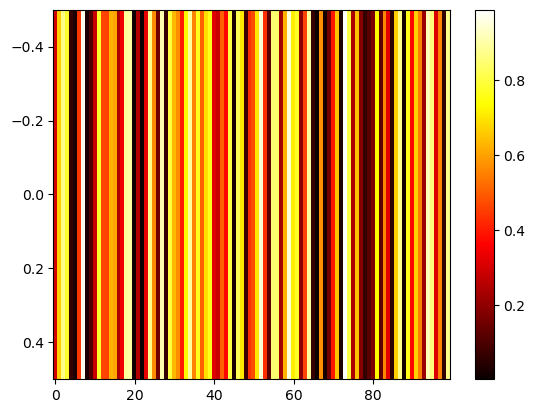

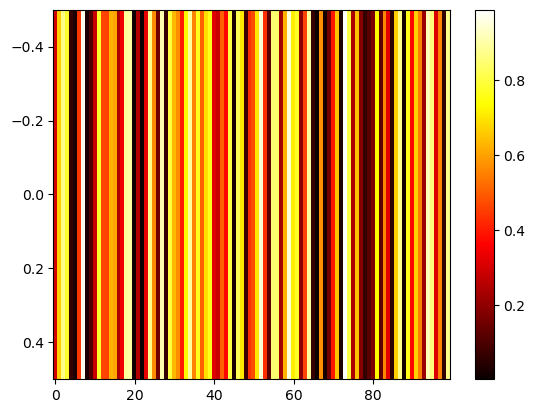

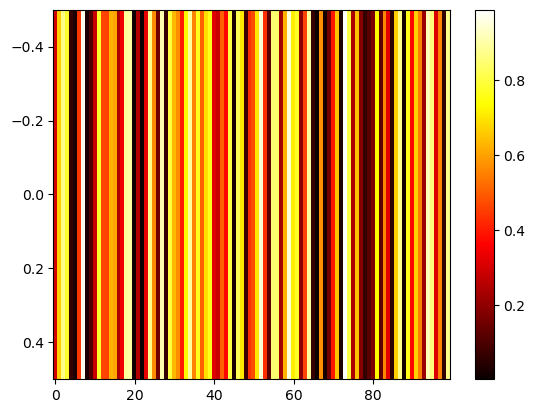

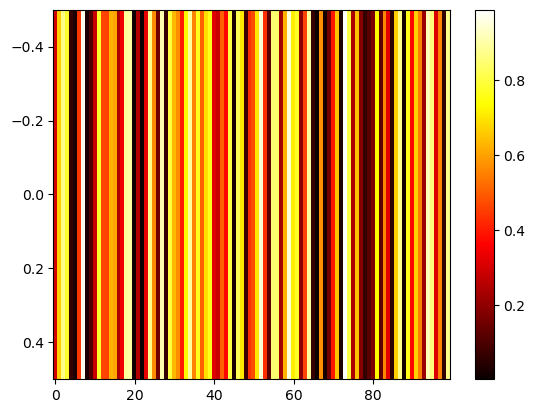

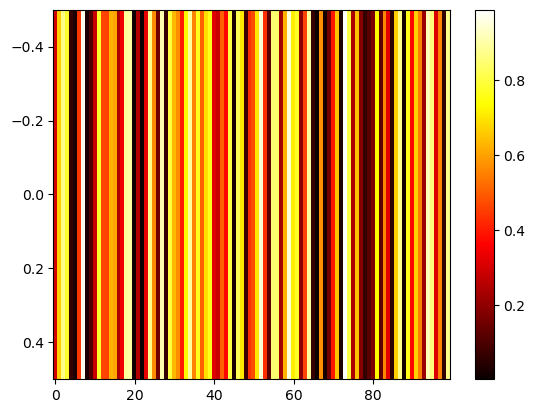

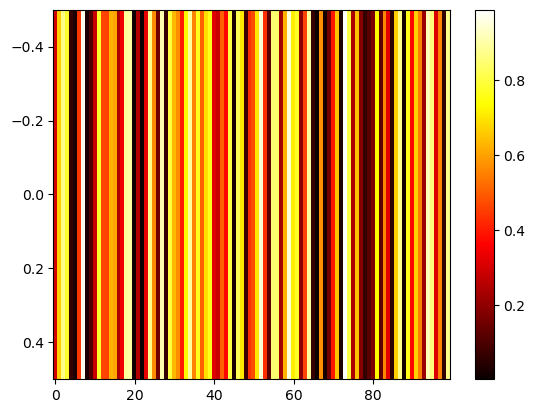

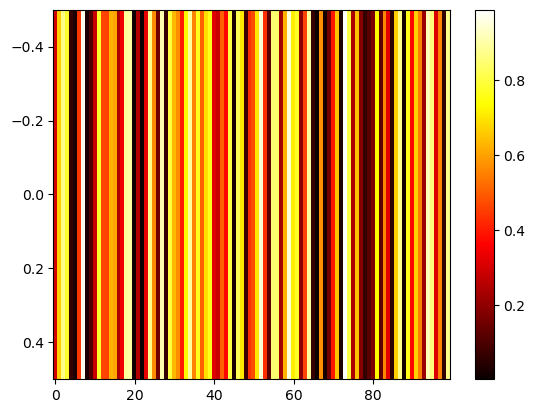

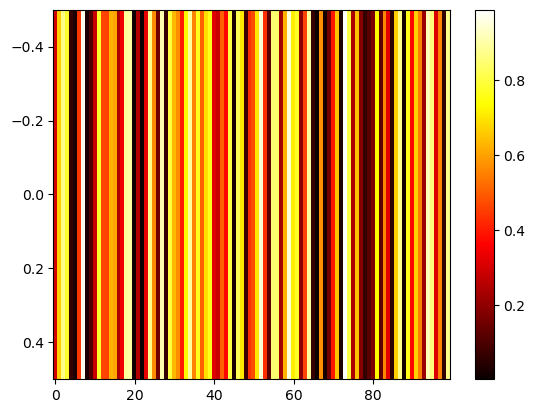

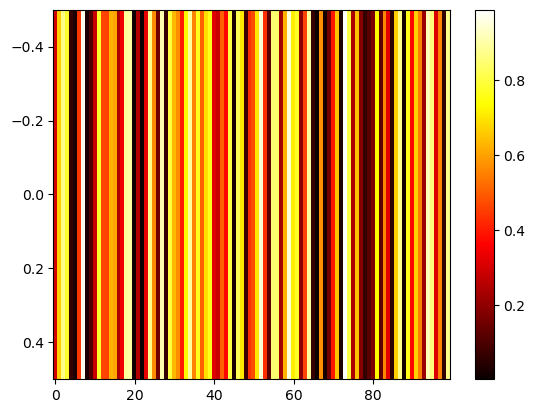

In [26]:
#plot example of nodes
dt = 10.0 
accumulated_time = 0.0
last_accumulated_time_remainder = 0.0

# Dummy data for the z value, should be replaced by actual data
z = np.random.rand(100, 100)  # Example raster (replace with your actual data)

while accumulated_time < 1000.0:
    accumulated_time += dt
    if last_accumulated_time_remainder < accumulated_time % 100.0:
        plt.imshow(z[int(z.shape[0] // 2), :].reshape(1, -1), aspect='auto', cmap='hot')
        plt.colorbar()
        plt.show()
        last_accumulated_time_remainder = accumulated_time % 100.0

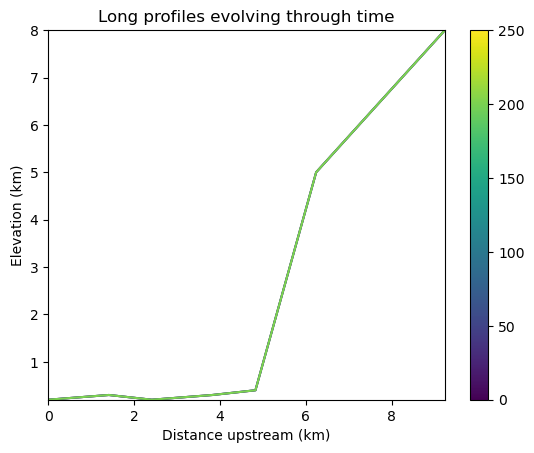

In [120]:
from matplotlib.pyplot import loglog

from landlab.components import ChannelProfiler, PrecipitationDistribution

#plot the PrecipitationDistribution
dt = 0.1
tot_t = 250.0

precip = PrecipitationDistribution(
    mean_storm_duration=1.5,
    mean_interstorm_duration=15.0,
    mean_storm_depth=0.5,
    total_t=tot_t,
    delta_t = dt
)


# make a color mapping appropriate for our time duration
norm = mpl.colors.Normalize(vmin=0, vmax=tot_t)
map_color = mpl.cm.ScalarMappable(norm=norm, cmap="viridis")

out_interval = 100
# last_trunc = total_t  # we use this to trigger taking an output plot

storms = list(precip.yield_storm_interstorm_duration_intensity())
elapsed_time = 0.0

for storm in range(len(storms)):
    interval_duration, rainfall_rate = storms[storm]

    # note diffusion also only happens when it's raining...
    if rainfall_rate > 0.0:
        fa.run_one_step()
        sp.run_one_step(interval_duration)
        lin_diffuse.run_one_step(interval_duration)

    z[mg.core_nodes] += uplift_rate * interval_duration

    elapsed_time += interval_duration

    if storm % out_interval == 0:
        cp = ChannelProfiler(mg)
        cp.run_one_step()
        cp.plot_profiles(color=map_color.to_rgba(elapsed_time))


plt.xlabel("Distance upstream (km)")
plt.ylabel("Elevation (km)")
plt.title("Long profiles evolving through time")
mpl.pyplot.colorbar(map_color, ax=mpl.pyplot.gca())

### 6. Finalize and handle the data

Once the looping is complete, the model is effectively finished. However, you
will still need to output the data somehow! Some options include:

#### Save or export the data

If you're using a raster grid, you can easily save your grid output to either
ESRI ascii (i.e., ARCmap) or open source netCDF formats. netCDF in particular is
a powerful format, and allows easy subsequent re-loading of a Landlab modelgrid
and all its fields. Save your raster like this:

### Save as an ASCII

In [101]:
from landlab.io import esri_ascii

print(esri_ascii.dump(mg, at="node"))

NROWS 7
NCOLS 7
CELLSIZE 0.5
XLLCENTER 0.0
YLLCENTER 0.0
NODATA_VALUE -9999



### Save as NetCDF

In [119]:
from landlab.io.netcdf import to_netcdf #importing the to_netcdf converter

import tempfile, os #creates a temp directory
temp_dir = tempfile.mkdtemp()
os.chdir(temp_dir)

test = to_netcdf(mg, "test.nc", format="NETCDF3_64BIT", include="at_node:uplift_rate") #example save

> ***NOTE***
> If you're running inside an interactive Python session like iPython,
> all the variables and objects (both grid and component) that you've used in your
> model will still be available in the environment. Thus, you can play with your
> data for as long as you want!



#### Animating figures

Due to issues surrounding platform-dependent video codecs, Landlab does not currently
support native video or animated output. However, numerous effective hacks using free
third party software can be effective. We recommend saving your figure for animation
at the desired frame interval using the matplotlib `savefig` command, then
stitching these images together into a video file externally.

DEJH has had a lot of success doing this in Preview on a Mac (which has the great
advantage that it is always available). Simply open the first image, go to `Export...`
under file, then **while holding down alt** click on the `Format` button to gain
access to a list of extra formats, including `.gif`. Open your new gif file, also
in preview, then just drag the remaining image files into the sidebar onto the first
slide, where they will be appended to the gif as individual frames. Save, and you
will now have an animated gif of your output (note you'll have to open the file in a
browser or drag it into Powerpoint to get it to run - for mysterious reasons,
Preview always opens the frames as images, and cannot show the gif running!).